In [1]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import layer_utils, np_utils
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import LearningRateScheduler
import math

Using TensorFlow backend.


In [42]:
train_dir = "C:/Users/hp/Desktop/SL_DR_Dataset/Disease_Grading/Original_Images/random_train_test/classified_train_destination_600"
validation_dir = "C:/Users/hp/Desktop/SL_DR_Dataset/Disease_Grading/Original_Images/random_train_test/validation"

image_width = 256
image_height = 256
batchsize = 16

vgg_16_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [43]:
# Freeze the layers except the last 2 layers
for layer in vgg_16_model.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_16_model.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x00000200757F5C18> False
<keras.layers.convolutional.Conv2D object at 0x00000200757F5630> False
<keras.layers.convolutional.Conv2D object at 0x00000200757F5828> False
<keras.layers.pooling.MaxPooling2D object at 0x000002007580F908> False
<keras.layers.convolutional.Conv2D object at 0x00000200758029E8> False
<keras.layers.convolutional.Conv2D object at 0x0000020075825400> False
<keras.layers.pooling.MaxPooling2D object at 0x00000200753EB3C8> False
<keras.layers.convolutional.Conv2D object at 0x0000020076838C88> False
<keras.layers.convolutional.Conv2D object at 0x00000200753E9438> False
<keras.layers.convolutional.Conv2D object at 0x00000200753EDEF0> False
<keras.layers.pooling.MaxPooling2D object at 0x00000200753EC4A8> False
<keras.layers.convolutional.Conv2D object at 0x00000200749F3710> False
<keras.layers.convolutional.Conv2D object at 0x00000200749F3F28> False
<keras.layers.convolutional.Conv2D object at 0x00000200749F25C0> False
<keras.

In [44]:
vgg_16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [45]:
def dataGen():
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=batchsize,
        shuffle=True,
        class_mode='categorical')
    
    validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(image_width, image_height),
            batch_size=batchsize,
            class_mode='categorical',
            shuffle=False)
    
    return train_generator, validation_generator

In [46]:
def trainValidationAccuracy(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [47]:
def step_decay(epoch):
    lr_0 = 0.0008
    decay_rate = 10
    lrate = lr_0 * 1/(1+decay_rate * epoch)
    return lrate

In [48]:
def modelBuilder(train_generator, validation_generator, intermediate_layer_model, path):   
    # Compile the model
    #optimizer=optimizers.adam(lr=0.0008)
    intermediate_layer_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.adam(lr=1e-4, decay=0.0),
                  metrics=['acc'])
    model_check_point_loc = 'D:/retinal_samples/basian_opt_testing/models/vgg16/' + path
    model_checkpoint = ModelCheckpoint(model_check_point_loc, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    # learning schedule callback
    #lrate = LearningRateScheduler(step_decay)
    # Train the model
    history = intermediate_layer_model.fit_generator(
          train_generator,
          steps_per_epoch=train_generator.samples//train_generator.batch_size,
          epochs=20,
          callbacks=[model_checkpoint],
          validation_data=validation_generator,
          validation_steps=validation_generator.samples//validation_generator.batch_size,
          verbose=1)
    
    # Save the model
    #intermediate_layer_model.save('D:/retinal_samples/basian_opt_testing/models/vgg16/' + path)
    trainValidationAccuracy(history)

In [49]:
train_generator, validation_generator = dataGen()

Found 2769 images belonging to 5 classes.
Found 126 images belonging to 5 classes.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

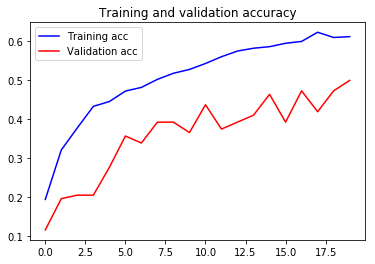

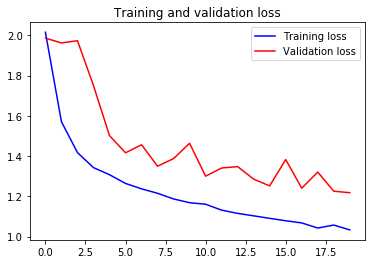

In [50]:
flatten = Flatten()
#new_classifier_layer = Dense(5, activation='softmax', name='predictions', kernel_regularizer=regularizers.l2(0.0001))

vgg_16_model_dup2 = vgg_16_model

inp_dup2 = vgg_16_model_dup2.input
#x = Dropout(0.1, name='maxpool_dropout')(vgg_16_model_dup2.output)
#out_dup2 = new_classifier_layer(flatten(x))
#out_dup2 = new_classifier_layer(flatten(vgg_16_model_dup2.output))
#out = new_classifier_layer(flatten(vgg_16_model_dup2.output))

#x = vgg_16_model_dup2.get_layer(index = -1).output
x = vgg_16_model_dup2.get_layer('block4_pool').output
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.5, name='flatten_dropout')(x)
#x = BatchNormalization()(x)
#x = flatten(vgg_16_model_dup2.get_layer(index = -1).output)
#x = BatchNormalization()(x)
#x = Dropout(0.5, name='flatten_dropout')(x)
##################Additional Layer######################
# x = Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(0.001))(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5, name='fc1_dropout')(x)
################End Additional Layer####################
#x = Dense(5, use_bias=False, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dense(5, use_bias=False, kernel_initializer='normal')(x)
#x = Dense(5, use_bias=False)(x)
x = BatchNormalization()(x)
out_dup2 = Activation('softmax')(x)
#out_dup2 = new_classifier_layer(x)

intermediate_layer_model_rcl1 = Model(inp_dup2, out_dup2)
intermediate_layer_model_rcl1.summary()

modelBuilder(train_generator, validation_generator, intermediate_layer_model_rcl1, 'vgg16_dr_rmFCdrp.h5')

In [13]:
output = vgg_16_model.get_layer(index = -1).output
output = GlobalAveragePooling2D()(output)
# let's add a fully-connected layer
output = Dense(256, activation='relu')(output)
# and a logistic layer -- let's say we have 200 classes
output = Dense(5, activation='softmax')(output)


vgg16_model = Model(vgg_16_model.input, output)
vgg16_model.summary()

modelBuilder(train_generator, validation_generator, vgg16_model, 'vgg16_dr_rmFCdrp.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

KeyboardInterrupt: 

In [62]:
# #vgg_16_model.summary()
# new_classifier_layer_3 = Dense(5, activation='softmax', name='my_dense_3', kernel_regularizer=regularizers.l2(0.0001))

# vgg_16_model_dup2 = vgg_16_model
# vgg_16_model_dup2.layers.pop()
# vgg_16_model_dup2.layers.pop()
# vgg_16_model_dup2.layers.pop()
# vgg_16_model_dup2.layers.pop()
# vgg_16_model_dup2.summary()

# inp_dup2 = vgg_16_model_dup2.input
# out_dup2 = new_classifier_layer_3(flatten(vgg_16_model_dup2.output))
# #out = new_classifier_layer(flatten(vgg_16_model_dup2.output))

# intermediate_layer_model_rcl1 = Model(inp_dup2, out_dup2)
# intermediate_layer_model_rcl1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
vgg_16_model.input

<tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>

In [ ]:
# model_input = Input(shape=(224,224,3),name = 'image_input')

# output_vgg16_conv = vgg_16_model(model_input)
# x = Dropout(0.1, name='maxpool_dropout')(output_vgg16_conv)
# x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(5, activation='softmax', name='predictions', kernel_regularizer=regularizers.l2(0.001))(x)

# intermediate_layer_model_rFC = Model(inputs=model_input, outputs=x)
# intermediate_layer_model_rFC.summary()

# modelBuilder(train_generator, validation_generator, intermediate_layer_model_rFC, 'vgg16_dr_rmFC.h5')